In [8]:
# Bibliotecas
import matplotlib.pyplot as plt
import folium
import numpy as np
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

Gerações: 1
Melhor cobertura: 65.22 %


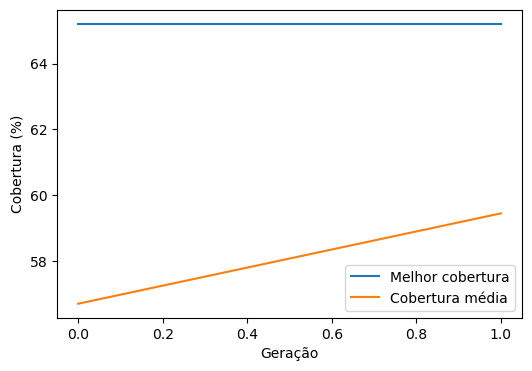

In [9]:
# 1 DADOS DO PROBLEMA DE ERBs
# 1.1 Carrega a geometria do município de Paço do Lamiar - MA
geojson_url = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-21-mun.json"
gdf = gpd.read_file(geojson_url)
gdf_municipio = gdf[gdf["name"] == "Paço do Lumiar"].reset_index(drop=True)
geometria_municipio = gdf_municipio.loc[0, "geometry"]

# 1.2 Carrega os Pontos de demanda
pontos_demanda = pd.read_csv("C:/Users/Romul/Documents/Visual_Studio/TCC/pontos_demanda/pontos_demanda.csv")
latmin_pd = pontos_demanda["latitude"].min()
latmax_pd = pontos_demanda["latitude"].max()
lonmin_pd = pontos_demanda["longitude"].min()
lonmax_pd = pontos_demanda["longitude"].max()
pontos_demanda = pontos_demanda.values.tolist()

# 1.3 Gera as ERBs aleatoriamente dentro da geometria do município
def gerar_ERB(n_pontos):
  pontos = []
  while len(pontos) < n_pontos:
    y = np.random.uniform(latmin_pd, latmax_pd)
    x = np.random.uniform(lonmin_pd, lonmax_pd)
    ponto = Point(x, y)
    if geometria_municipio.contains(ponto):
      pontos.append((y, x))
  return pontos

# 1.4 Raio estimado de cobertura de uma ERB 5G
raio = 900   # metros

# 1.5 Qtd de ERBs por indivíduo
erbs_por_individuo = 40

# 1.6 Função objetivo
def funcao_objetivo(populacao, pontos_demanda, raio_metros):
  resultados = []
  m = len(pontos_demanda)

  for individuo in populacao:
    Mi = np.zeros(m)

    for i, ponto in enumerate(pontos_demanda):
      for erb in individuo:
        distancia = geodesic(ponto, erb).meters
        if distancia < raio_metros:
          Mi[i] = 1
          break

    f = (np.sum(Mi) * 100) / m
    resultados.append(f)

  return np.array(resultados)

# 2 INÍCIO DO AlGORITMO GENÉTICO
# 2.1 Critérios de parada do loop
max_iteracoes = 1     # Número máximo de gerações
cobertura_max = 100   # Cobertura máxima (100%)

# 2.2 Parâmetros do AG
tam_pop = 16  # Tamanho da população
tx_mut = 0.2  # Taxa de mutação
tx_selec = 0.5 # Taxa de seleção
sobreviventes = int(np.floor(tx_selec * tam_pop))
num_mut = int(np.ceil(tam_pop * tx_mut)) # Número de mutações
num_cruzamentos = int(np.ceil((tam_pop - sobreviventes) / 2)) # Número de cruzamentos

# 2.3 População inicial
geracao = 0
populacao = np.array([gerar_ERB(erbs_por_individuo) for _ in range(tam_pop)])
cobertura = funcao_objetivo(populacao, pontos_demanda, raio)
indices_ordenados_decre = np.argsort(-cobertura)
cobertura = cobertura[indices_ordenados_decre]
populacao = populacao[indices_ordenados_decre]
melhor_cobertura = [np.max(cobertura)]
cobertura_media = [np.mean(cobertura)]

# 2.4 Iterar por gerações
while geracao < max_iteracoes:
  geracao += 1

  # 2.4.1 Seleção dos pais
  pesos = np.flip(np.arange(1, sobreviventes + 1)) / np.sum(np.arange(1, sobreviventes + 1))
  distribuicao = np.hstack(([0], np.cumsum(pesos)))
  selecao_1 = np.random.rand(num_cruzamentos)
  selecao_2 = np.random.rand(num_cruzamentos)
  mae = []
  pai = []
  for s1, s2 in zip(selecao_1, selecao_2):
    mae.append(np.searchsorted(distribuicao, s1) - 1)
    pai.append(np.searchsorted(distribuicao, s2) - 1)

  # 2.4.2 Cruzamento
  fator_mistura = np.random.rand(erbs_por_individuo)

  for i in range(num_cruzamentos):
    m = mae[i]
    p = pai[i]

    descendente1 = np.copy(populacao[m])
    mae_ = np.copy(populacao[m])
    descendente2 = np.copy(populacao[p])
    pai_ = np.copy(populacao[p])

    for j in range(erbs_por_individuo):
      if fator_mistura[j] < 0.5:
        descendente1[j] = pai_[j]
        descendente2[j] = mae_[j]

    # Adiciona os descendentes à população
    populacao[sobreviventes + 2 * i] = descendente1
    populacao[sobreviventes + 2 * i + 1] = descendente2

  # 2.4.3 Mutar a população
  mut_linhas = np.random.randint(1, tam_pop, size=num_mut)
  mut_colunas = np.random.randint(0, erbs_por_individuo, size=num_mut)

  for linha, coluna in zip(mut_linhas, mut_colunas):
    populacao[linha, coluna] = gerar_ERB(1)[0]

  # 2.4.3 Checar a convergência
  cobertura = funcao_objetivo(populacao, pontos_demanda, raio)

  # 2.4.4 Ordena a cobertura e os individuos associados
  indices_ordenados_decre = np.argsort(-cobertura)
  cobertura = cobertura[indices_ordenados_decre]
  populacao = populacao[indices_ordenados_decre]

  # 2.4.5 Estatísticas para uma única geração
  melhor_cobertura.append(np.max(cobertura))
  cobertura_media.append(np.mean(cobertura))

  # 2.4.6 Parada por cobertura máxima
  if cobertura.max() >= cobertura_max:
    break

# 2.5 Resultados
# 2.5.1 Valor numérico
print(f"Gerações: {geracao}")
print(f"Melhor cobertura: {cobertura[0]:.2f} %")

# 2.5.2 Visualização da evolução da cobertura
plt.figure(figsize=(6, 4))
plt.plot(range(max_iteracoes + 1), melhor_cobertura, label="Melhor cobertura")
plt.plot(range(max_iteracoes + 1), cobertura_media, label="Cobertura média")
# plt.title("Evolução da cobertura")
plt.xlabel("Geração")
plt.ylabel("Cobertura (%)")
plt.legend(loc="lower right")
plt.show()

In [10]:
# 2.5.3 Mapa da melhor cobertura gerada
lon_min, lat_min, lon_max, lat_max = geometria_municipio.bounds
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2
mapa = folium.Map(location=[center_lat, center_lon], zoom_start=12, width=500, height=350, zoomControl=False)

folium.GeoJson(
  geometria_municipio,
  style_function=lambda x: {
    "fillColor": "blue",
    "color": "blue",
    "weight": 2,
    "fillOpacity": 0.1,
  }
).add_to(mapa)

for ponto in pontos_demanda:
  folium.CircleMarker(
    location=[ponto[0], ponto[1]],
    radius=2,
    color="blue",
    fill=True,
    fill_color="blue",
    fill_opacity=1
  ).add_to(mapa)

for ponto in populacao[0]:
  folium.Circle(
    location=[ponto[0], ponto[1]],
    radius=raio,
    color=None,
    fill=True,
    fill_color="orange",
    fill_opacity=0.7,
    popup=f"Coordenada: [{ponto[0]}, {ponto[1]}]"
  ).add_to(mapa)
mapa

In [11]:
# Salva o mapa em HTML
mapa.save("C:/Users/Romul/Documents/Visual_Studio/TCC/AG/mapa_cobertura.html")